# Homework 4: Ising Spins

Consider $i = 1, \ldots, N$ spins taking values $S_i = \pm 1$, on a 2D grid of size $(L \times L)$, with $N = L^2$ and periodic boundary conditions. The Hamiltonian reads:

$$
H= - \displaystyle \sum_{\langle ij \rangle} s_i s_j
$$

where $\langle ij \rangle$ denote the complete set of links $i,j$ on the 2D grid. Using the convention $k_B = J = 1$, so that $\beta = 1/T$.

## Metropolis rule

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

In [2]:
class lattice(object):
    def __init__(self, L, T, **kwargs):
        # initialize the 2D lattice in an ordered state if
        # key config is "ordered", and in a random state if
        # key config is "random". Default = "random".
        # Also define T and initialize two empty vectors to 
        # collect values  of energy and magnetization at 
        # each MCMC step.
        self.start_config = kwargs.get("config", "random")
        if self.start_config == "random":
            self.grid = np.random.choice([1, -1], [L, L])
        elif self.start_config == "ordered":
            self.grid = np.ones([L, L])
        if T==0:
            self.beta = float("inf")
        else:
            self.beta = 1.0/T
        self.L = L
        self.energy = []
        self.magnetization = []
        self.t=[0]
        self.m_abs=[]
        self.m_2=[]
        self.m_4=[]
        self.g=[]
        
    def compute_energy(self):
        # compute the energy of a configuration as minus the sum
        # over neighbors of the product of spins
        energy = 0
        for i in xrange(self.L):
            for j in xrange(self.L):
                energy -= self.grid[i][j]*(self.grid[i][(j+1)%self.L]+\
                  self.grid[i][(j-1)%self.L] + \
                  self.grid[(i+1)%self.L][j] + \
                  self.grid[(i-1)%self.L][j])
        # divide by two otherwise counting twice
        return energy/(2.0*self.L**2)
                 
    def compute_magnetization(self):
        # compute the magnetization
        return np.sum(self.grid)/(1.0*self.L**2)
        
    def reset_observables(self):
        # reset energy and magnetization lists
        self.energy = []
        self.magnetization = []
    
    def MCMC(self, n_steps):
        # perform n_steps MCMC steps
        
        def delta_energy(grid, i, j):
            # compute delta energy between initial (a) and final 
            # state (b): E(a) - E(b) as twice the contribution 
            # over neighbours (using PBC) of the spin which would 
            # be flipped.
            delta_E = -2*grid[i][j]*(grid[i][(j+1) % (self.L)] + \
                  grid[i][(j-1) % (self.L)] + \
                  grid[(i+1)%self.L][j] + \
                  grid[(i-1)%self.L][j])
            return delta_E
        
        for step in xrange(n_steps):
            # choose randomly a spin by extracting two indices
            ix, iy = np.random.randint(0, self.L, size = 2)
            
            # Metropolis
            delta_E = delta_energy(self.grid, ix, iy)
            # p is min(1, exp(beta*(E(a) - E(b))))
            p = min([1, np.exp(self.beta*delta_E)])
            # first check p>1 to save a call to rand eventually
            if p > 1 or np.random.rand() < p:
                self.grid[ix][iy] *= -1
            
            self.energy.append(self.compute_energy())
            self.magnetization.append(self.compute_magnetization())
            
            if step%100000:
                print step
            
    def wolff(self, n_steps):
        
        # compute the probability of accepting a move
        p = 1 - np.exp(-2*self.beta)
        
        for step in xrange(n_steps):
            # choose randomly a spin by extracting two indices
            ix, iy = np.random.randint(0, self.L, size = 2)  
            # add selected spin to cluster and to the starting frontier
            C=[[ix,iy]]
            Fo=[[ix,iy]]
            
            # NOTE: empty sequences are false -> Fo is a boolean TRUE when not empty
            while Fo:
                Fn=[]
                # add spins to the cluster if they have the same sign of the starting one
                # with probability p
                for x, y in Fo:
                    if self.grid[x][y]==self.grid[(x+1)%self.L][y] and [(x+1)%self.L,y] not in C:
                        if np.random.rand() < p:
                            Fn.append([(x+1)%self.L,y])
                            C.append([(x+1)%self.L,y])
                    
                    if self.grid[x][y]==self.grid[(x-1)%self.L][y] and [(x-1)%self.L,y] not in C:
                        if np.random.rand() < p:
                            Fn.append([(x-1)%self.L,y])
                            C.append([(x-1)%self.L,y])
                            
                    if self.grid[x][y]==self.grid[x][(y+1)%self.L] and [x,(y+1)%self.L] not in C:
                        if np.random.rand() < p:
                            Fn.append([x,(y+1)%self.L])
                            C.append([x,(y+1)%self.L])
                            
                    if self.grid[x][y]==self.grid[x][(y-1)%self.L] and [x,(y-1)%self.L] not in C:
                        if np.random.rand() < p:
                            Fn.append([x,(y-1)%self.L])
                            C.append([x,(y-1)%self.L])
                
                # update the frontier
                Fo=copy.deepcopy(Fn)
            
            # flip the cluster
            for x, y in C:
                self.grid[x][y]*=-1
 
            # compute energy and magnetization
            self.energy.append(self.compute_energy())
            self.magnetization.append(self.compute_magnetization())
            self.t.append(self.t[step]+len(C)/(1.0*self.L**2))
    
    # vectorized operations are faster (just as in MATLAB, unlike Julia)
    def compute_observables(self):
        m = 1*np.asarray(self.magnetization)
        self.m_abs=np.average(abs(m)/(1.*self.L**2) )
        self.m_2=np.average( m**2 /(1.*self.L**2) )
        self.m_4=np.average( m**4 /(1.*self.L**2) )
        self.g=self.m_4/(3.0*self.m_2**2)
    
    def plot_lattice(self, **kwargs):
        self.title = kwargs.get("title", "")
        for i in xrange(self.L):
            for j in xrange(self.L):
                if self.grid[i][j] == 1:
                    plt.plot(i, j, "r^")
                else:
                    plt.plot(i, j, "bv")
        plt.xlim([-0.5, self.L - 0.5])
        plt.ylim([-0.5, self.L - 0.5])
        plt.title(self.title)
        plt.axes().set_aspect('equal')
        plt.show()

### Low and high T phases ($T_c \simeq 2.26918$)

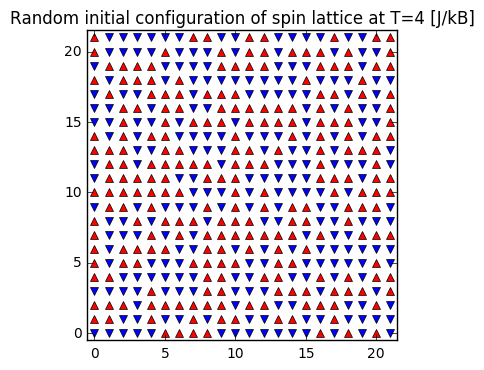

In [8]:
Ising_T4 = lattice(22, 4)
Ising_T4.plot_lattice(title="Random initial configuration of spin lattice at T=4 [J/kB]")

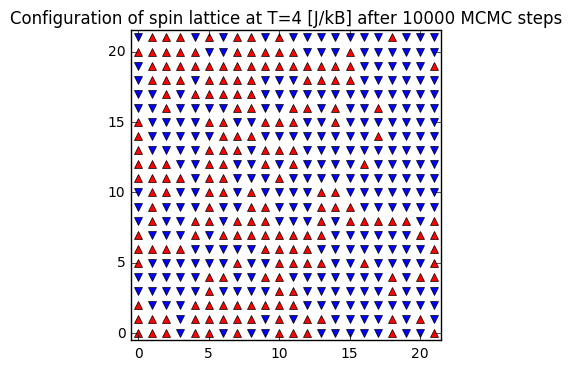

In [9]:
Ising_T4.MCMC(10000)
Ising_T4.plot_lattice(title="Configuration of spin lattice at T=4 [J/kB] after 10000 MCMC steps")

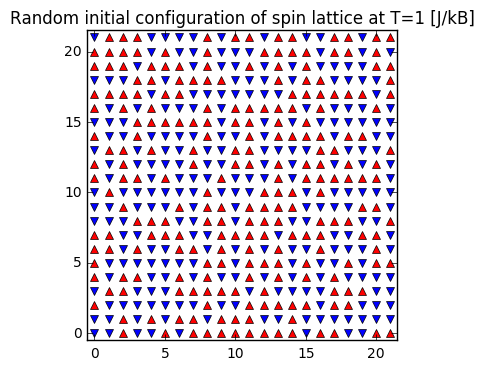

In [10]:
Ising_T1 = lattice(22, 1)
Ising_T1.plot_lattice(title="Random initial configuration of spin lattice at T=1 [J/kB]")

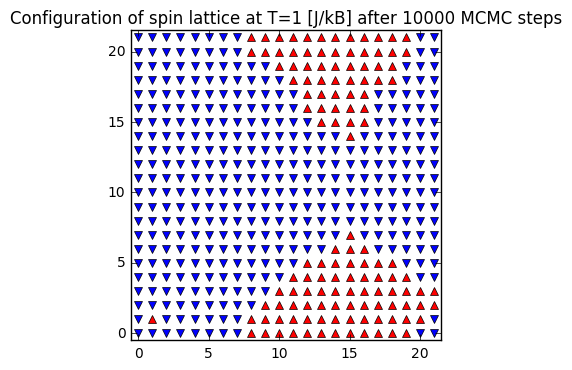

In [11]:
Ising_T1.MCMC(10000)
Ising_T1.plot_lattice(title="Configuration of spin lattice at T=1 [J/kB] after 10000 MCMC steps")

The critical temperature $T_c \simeq 2.26918$ separates a disordered phase at high $T$, in which the spins are randomly oriented and the average magnetization $m = \frac{1}{N} \displaystyle \sum_i s_i$ is zero, and an ordered phase at low $T$, in which $m \neq 0$.  
After a few steps, it is already evident that for $T=4$ we are in the disordered phase, while for $T=1$ and order is emerging.

### High T phase

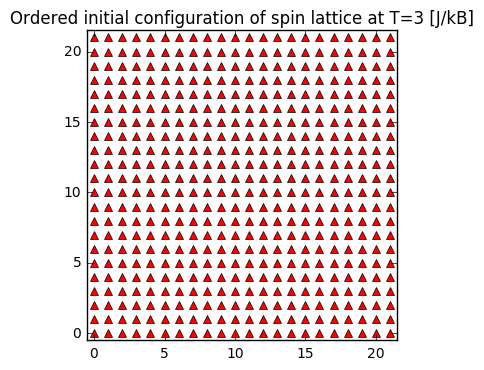

In [10]:
Ising_T3 = lattice(22, 3, config="ordered")
Ising_T3.plot_lattice(title="Ordered initial configuration of spin lattice at T=3 [J/kB]")

In [ ]:
Ising_T3.MCMC(2000000)

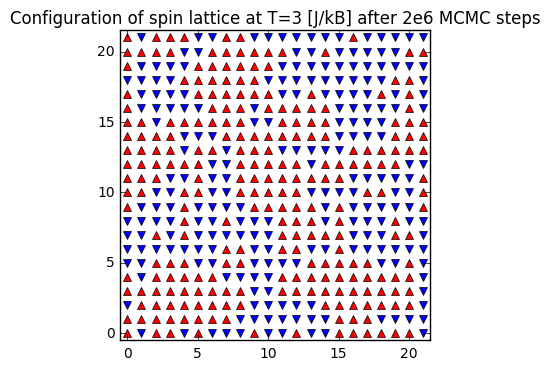

In [12]:
Ising_T3.plot_lattice(title="Configuration of spin lattice at T=3 [J/kB] after 2e6 MCMC steps")

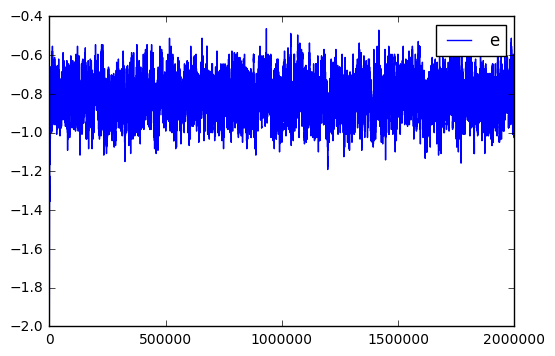

In [13]:
plt.plot(xrange(len(Ising_T3.energy)), Ising_T3.energy, label = "e")
plt.legend()
plt.show()

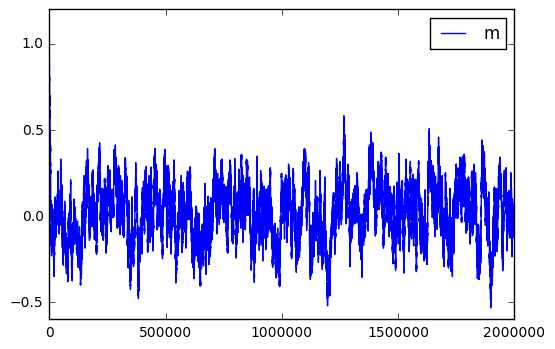

In [14]:
plt.plot(xrange(len(Ising_T3.magnetization)), Ising_T3.magnetization, label = "m")
plt.legend()
plt.show()

In [15]:
print np.mean(Ising_T3.magnetization) 
print np.var(Ising_T3.magnetization)

0.0189966880165
0.0259044450934


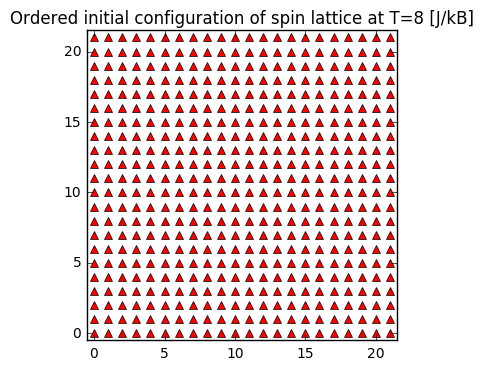

In [16]:
Ising_T8 = lattice(22, 8, config="ordered")
Ising_T8.plot_lattice(title="Ordered initial configuration of spin lattice at T=8 [J/kB]")

In [ ]:
Ising_T8.MCMC(2000000)

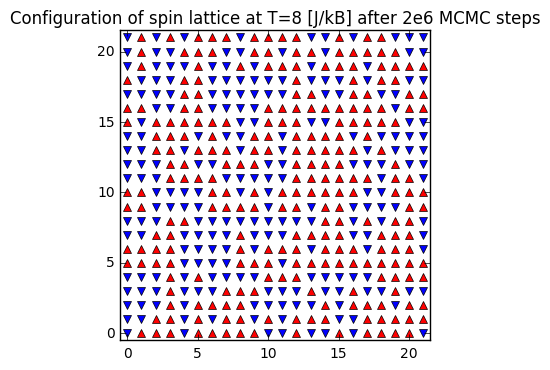

In [18]:
Ising_T8.plot_lattice(title="Configuration of spin lattice at T=8 [J/kB] after 2e6 MCMC steps")

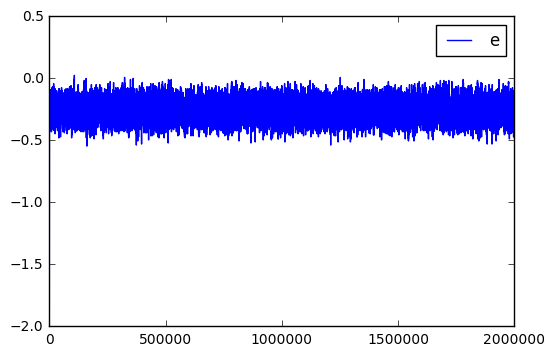

In [25]:
plt.plot(xrange(len(Ising_T8.energy)), Ising_T8.energy, label = "e")
plt.legend()
plt.show()

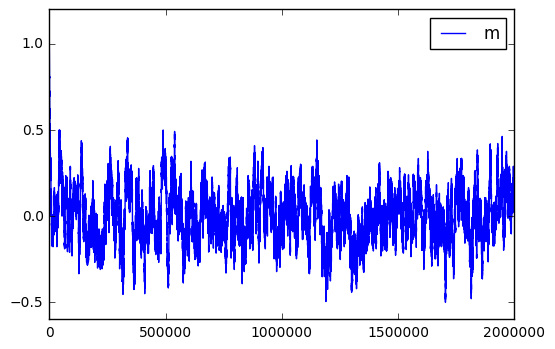

In [26]:
plt.plot(xrange(len(Ising_T8.magnetization)), Ising_T8.magnetization, label = "m")
plt.legend()
plt.show()

In [19]:
print np.mean(Ising_T8.magnetization) 
print np.var(Ising_T8.magnetization)

-0.000730564049587
0.00396762921757


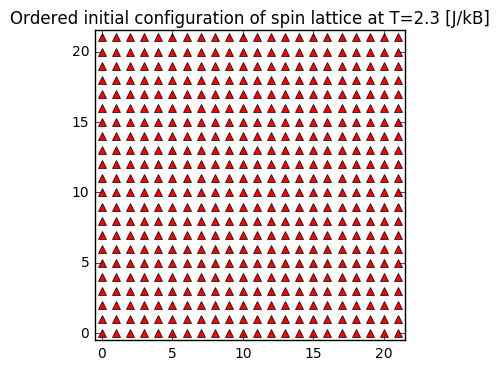

In [3]:
Ising_nearTc = lattice(22, 2.3, config="ordered")
Ising_nearTc.plot_lattice(title="Ordered initial configuration of spin lattice at T=2.3 [J/kB]")

In [4]:
Ising_nearTc.MCMC(5000000)

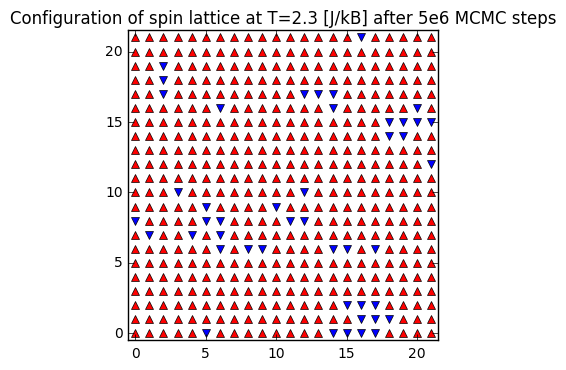

In [26]:
Ising_nearTc.plot_lattice(title="Configuration of spin lattice at T=2.3 [J/kB] after 5e6 MCMC steps")

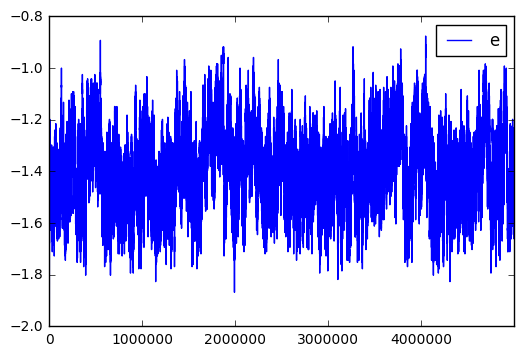

In [27]:
plt.plot(xrange(len(Ising_nearTc.energy)), Ising_nearTc.energy, label = "e")
plt.xticks(np.arange(0, 5000000, 1000000))
plt.legend()
plt.show()

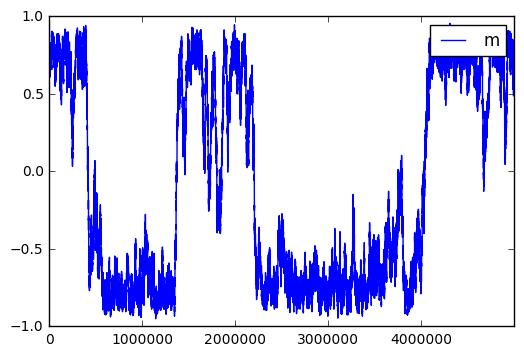

In [28]:
plt.plot(xrange(len(Ising_nearTc.magnetization)), Ising_nearTc.magnetization, label = "m")
plt.xticks(np.arange(0, 5000000, 1000000))
plt.legend()
plt.show()

At high temperature, the magnetization oscillates around $m=0$ due to thermal fluctuations.  

At $T$ close to $T_c$, the system has huge fluctuations and the probability distribution of the states is almost flat.    
In proximity of a phase transition, there is a **critical slowdown**, the correlation time diverges as a power of the correlation length which is bounded by the size of the system. The problem with MCMC is that the autocorrelation time near the critical point diverges as a power of the size of the system, so in $5\cdot 10^6$ steps only few samples will be independent and to obtain reasonable estimates one should go for very long runs.

### Low T phase

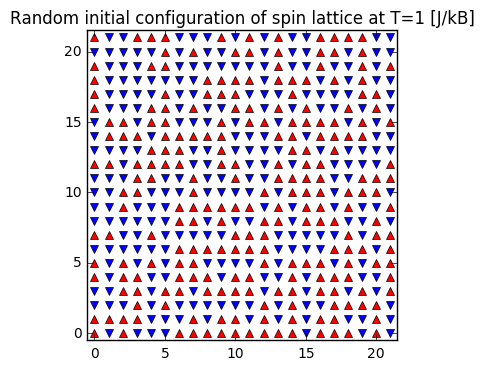

In [4]:
Ising_T1 = lattice(22, 1)
Ising_T1.plot_lattice(title="Random initial configuration of spin lattice at T=1 [J/kB]")

In [5]:
Ising_T1.MCMC(3000000)

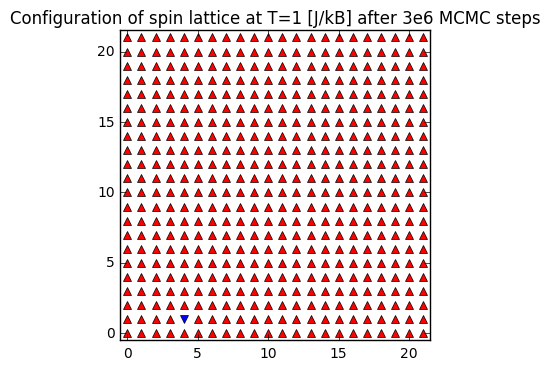

In [6]:
Ising_T1.plot_lattice(title="Configuration of spin lattice at T=1 [J/kB] after 3e6 MCMC steps")

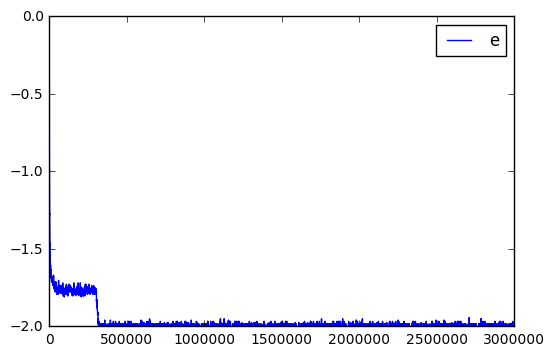

In [7]:
plt.plot(xrange(len(Ising_T1.energy)), Ising_T1.energy, label = "e")
plt.legend()
plt.show()

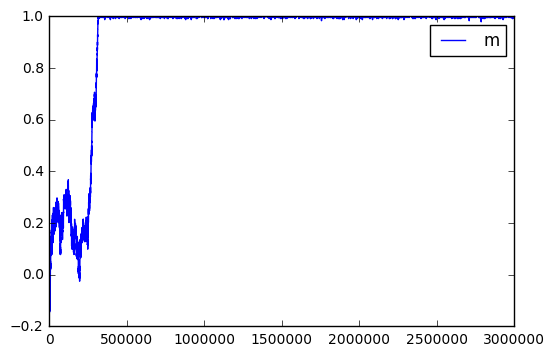

In [8]:
plt.plot(xrange(len(Ising_T1.magnetization)), Ising_T1.magnetization, label = "m")
plt.legend()
plt.show()

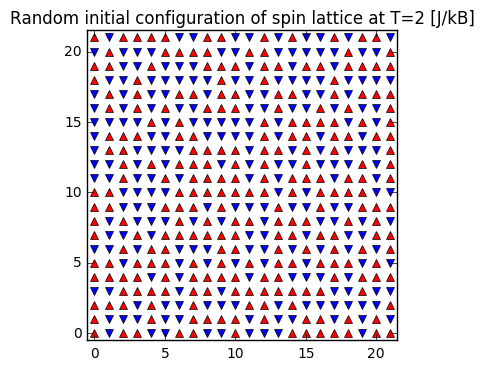

In [30]:
Ising_T2 = lattice(22, 2)
Ising_T2.plot_lattice(title="Random initial configuration of spin lattice at T=2 [J/kB]")

In [ ]:
Ising_T2.MCMC(3000000)

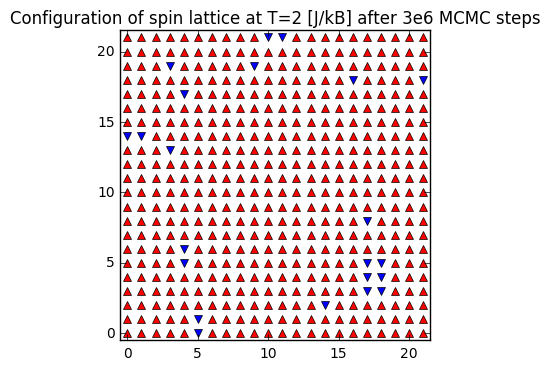

In [33]:
Ising_T2.plot_lattice(title="Configuration of spin lattice at T=2 [J/kB] after 3e6 MCMC steps")

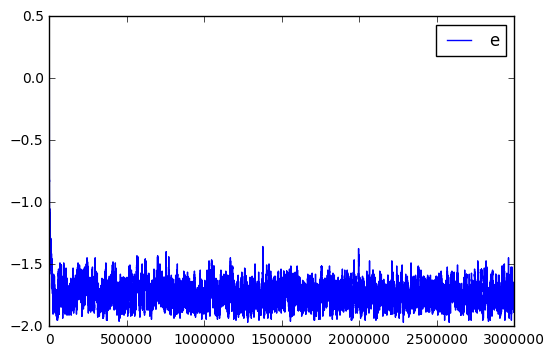

In [34]:
plt.plot(xrange(len(Ising_T2.energy)), Ising_T2.energy, label = "e")
plt.legend()
plt.show()

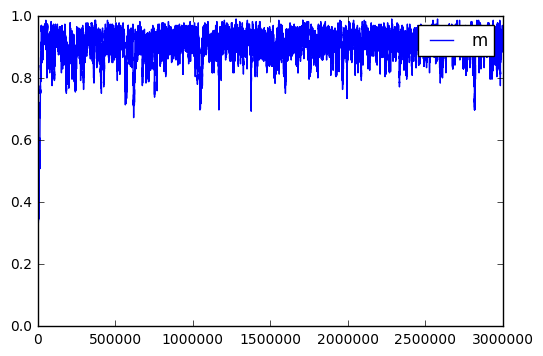

In [35]:
plt.plot(xrange(len(Ising_T2.magnetization)), Ising_T2.magnetization, label = "m")
plt.legend()
plt.show()

In [37]:
print np.mean(Ising_T2.magnetization)
print np.var(Ising_T2.magnetization)

0.907948213499
0.00305359815248


At low T the system goes towards an ordered configuration with $m \neq 0$. Now we analyze what happens for $T=0$ (achieved by setting $\beta \to \infty$). Let's make evolve twenty different systems at $T=0$ from an initial random configuration.

In [46]:
Ising_systems_T0 = []
for i in xrange(20):
    Ising_systems_T0.append(lattice(22, 0))

In [47]:
for system in Ising_systems_T0:
    system.MCMC(100000)

In [48]:
for i in xrange(len(Ising_systems_T0)):
    print i, Ising_systems_T0[i].magnetization[-1]

0 0.0
1 1.0
2 -0.181818181818
3 1.0
4 -1.0
5 -1.0
6 -1.0
7 -1.0
8 -1.0
9 1.0
10 1.0
11 0.181818181818
12 0.0
13 1.0
14 1.0
15 1.0
16 -1.0
17 -1.0
18 -1.0
19 1.0


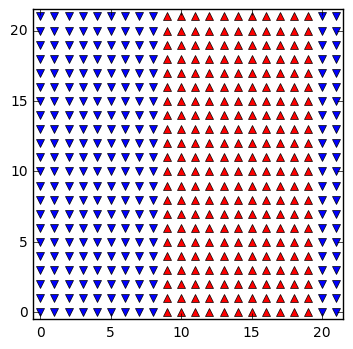

In [49]:
Ising_systems_T0[0].plot_lattice()

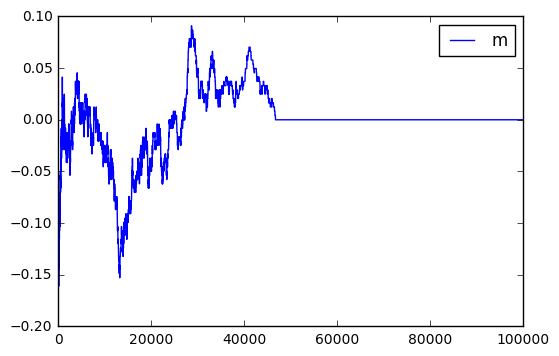

In [53]:
plt.plot(xrange(len(Ising_systems_T0[0].magnetization)), Ising_systems_T0[0].magnetization, label = "m")
plt.legend()
plt.show()

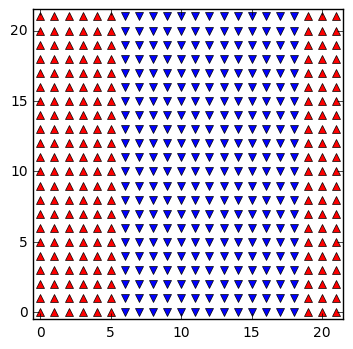

In [51]:
Ising_systems_T0[2].plot_lattice()

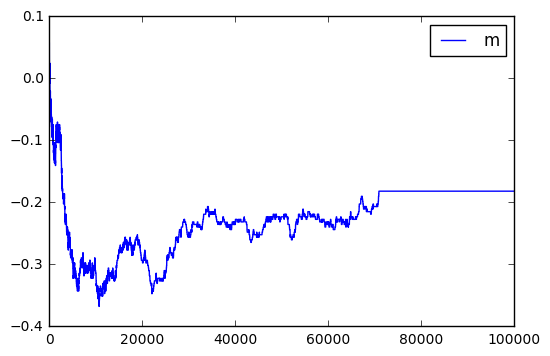

In [52]:
plt.plot(xrange(len(Ising_systems_T0[2].magnetization)), Ising_systems_T0[2].magnetization, label = "m")
plt.legend()
plt.show()

We see that not all have reached a state with $m=\pm 1$. This happens because there are configurations with a band of spins of opposite sign, from which the system can not move (like the two shown above).

## Wolff algorithm

### High T

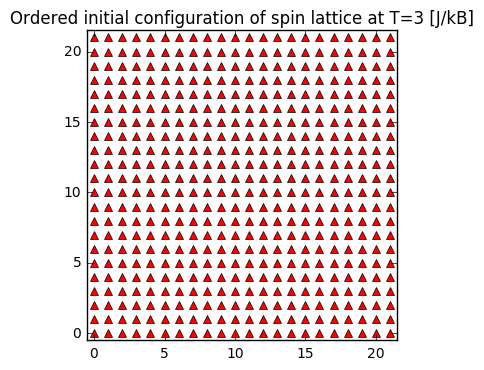

In [16]:
Ising_T3 = lattice(22, 3, config="ordered")
Ising_T3.plot_lattice(title="Ordered initial configuration of spin lattice at T=3 [J/kB]")

In [ ]:
Ising_T3.wolff(500)

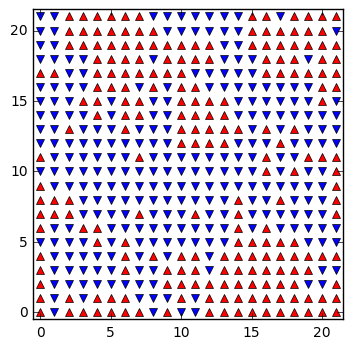

In [18]:
Ising_T3.plot_lattice()

In [31]:
print np.mean(Ising_T3.magnetization)
print np.var(Ising_T3.magnetization)
print np.mean(Ising_T3.energy)
print np.var(Ising_T3.energy)

-0.00451239669421
0.0305782312684
-0.86494214876
0.0129101178881


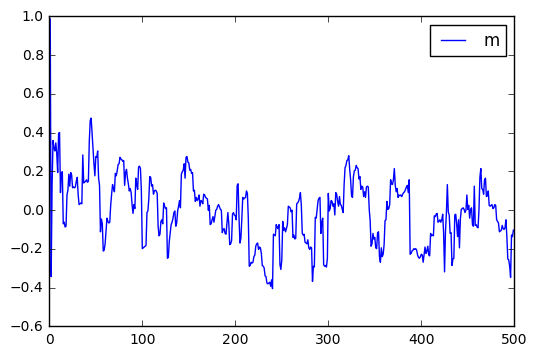

In [20]:
plt.plot(xrange(len(Ising_T3.magnetization)), Ising_T3.magnetization, label = "m")
plt.legend()
plt.show()

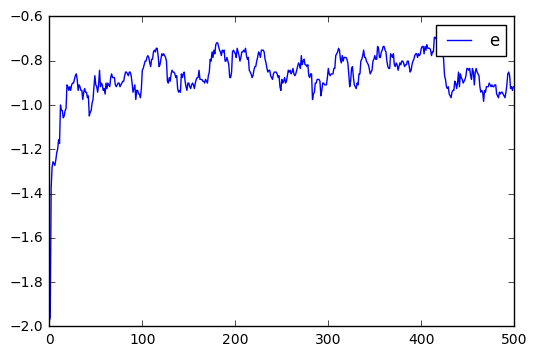

In [21]:
plt.plot(xrange(len(Ising_T3.energy)), Ising_T3.energy, label = "e")
plt.legend()
plt.show()

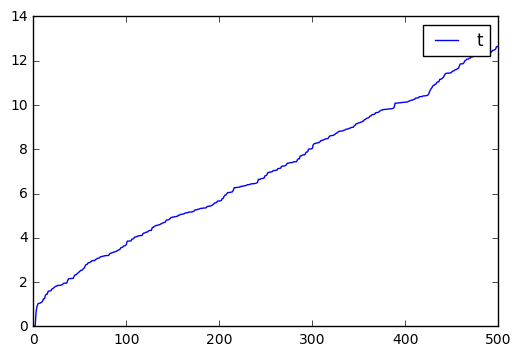

In [22]:
plt.plot(xrange(len(Ising_T3.t)), Ising_T3.t, label = "t")
plt.legend()
plt.show()

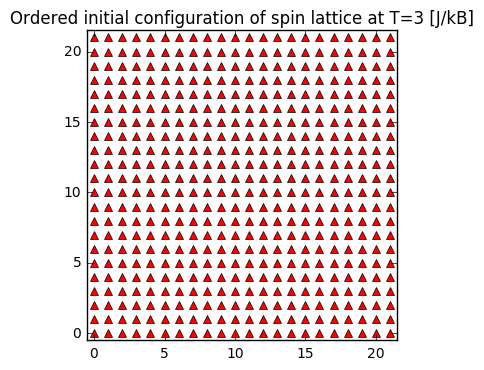

In [30]:
Ising_T3 = lattice(22, 3, config="ordered")
Ising_T3.plot_lattice(title="Ordered initial configuration of spin lattice at T=3 [J/kB]")

In [34]:
Ising_T3.MCMC(10000)

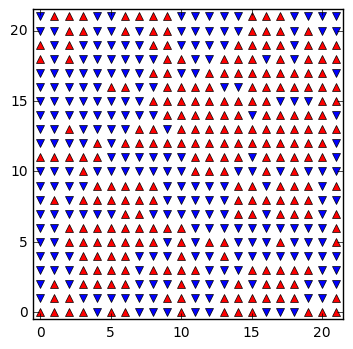

In [35]:
Ising_T3.plot_lattice()

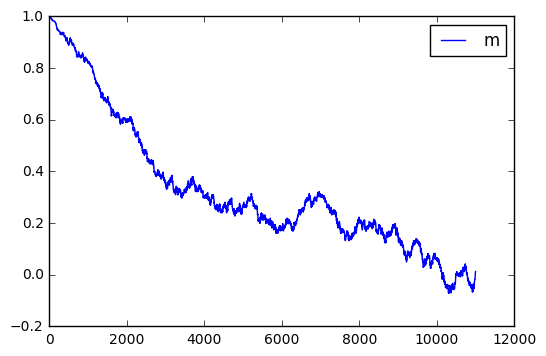

In [36]:
plt.plot(xrange(len(Ising_T3.magnetization)), Ising_T3.magnetization, label = "m")
plt.legend()
plt.show()

We see that MCMC converges after $\simeq 10^4$ steps. We define the time increase as $1/N$ every time we attempt to flip a spin and we compare MCMC to Wolff algorithm:  

$$t_{MCMC} \simeq 10^4/L^2 \simeq 20$$
$$t_{wolff} \simeq 2$$

Therefore Wolff algorithm reduces the time needed for convergence by an order of magnitude.  
Let's see what happens near $T_c$:

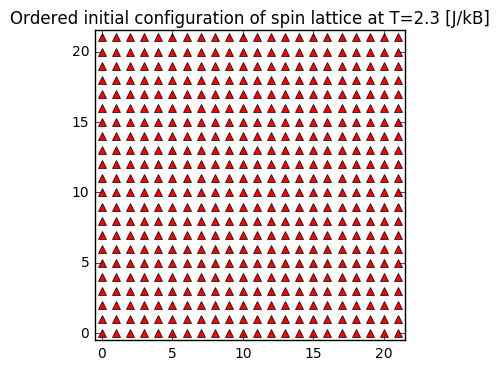

In [49]:
Ising_nearTc = lattice(22, 2.3, config="ordered")
Ising_nearTc.plot_lattice(title="Ordered initial configuration of spin lattice at T=2.3 [J/kB]")

In [50]:
Ising_nearTc.wolff(20000)

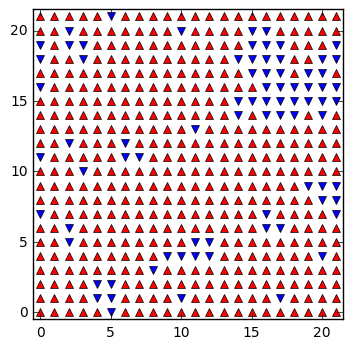

In [51]:
Ising_nearTc.plot_lattice()

In [52]:
print np.mean(Ising_nearTc.magnetization)
print np.var(Ising_nearTc.magnetization)
print np.mean(Ising_nearTc.energy)
print np.var(Ising_nearTc.energy)

0.00282169421488
0.426187641996
-1.38385702479
0.0193511958958


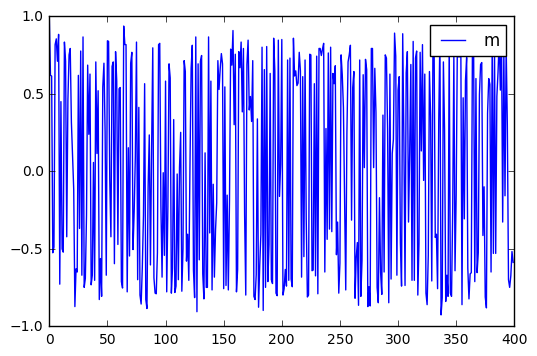

In [59]:
#show every 50 samples
plt.plot(xrange(len(Ising_nearTc.magnetization[0::50])), Ising_nearTc.magnetization[0::50], label = "m")
plt.legend()
plt.show()

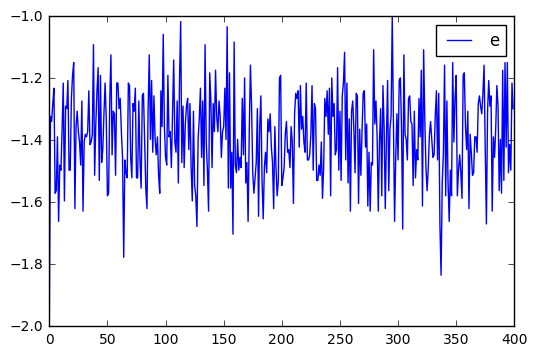

In [60]:
plt.plot(xrange(len(Ising_nearTc.energy[0::50])), Ising_nearTc.energy[0::50], label = "e")
plt.legend()
plt.show()

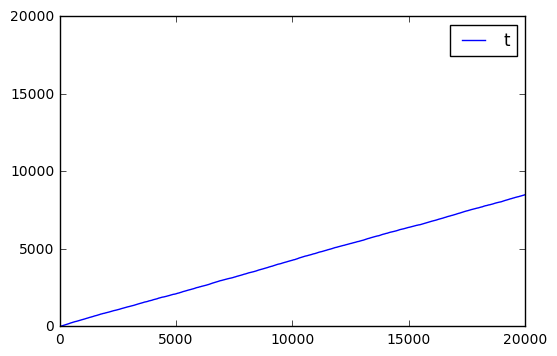

In [61]:
plt.plot(xrange(len(Ising_nearTc.t)), Ising_nearTc.t, label = "t")
plt.xlim([0, 20000])
plt.ylim([0, 20000])
plt.legend()
plt.show()

(array([ 0.17235,  0.1823 ,  0.07645,  0.04055,  0.03015,  0.03405,
         0.04915,  0.0979 ,  0.22985,  0.08725]),
 array([-0.9338843 , -0.74090909, -0.54793388, -0.35495868, -0.16198347,
         0.03099174,  0.22396694,  0.41694215,  0.60991736,  0.80289256,
         0.99586777]),
 <a list of 10 Patch objects>)

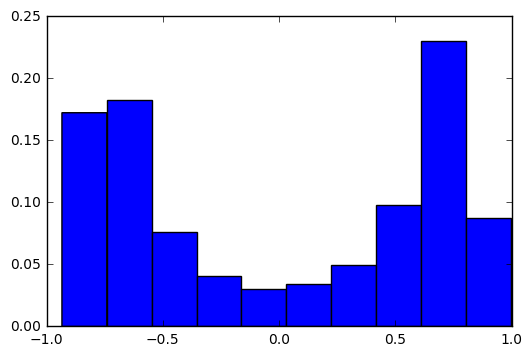

In [65]:
weights = np.ones_like(Ising_nearTc.magnetization)/len(Ising_nearTc.magnetization)
plt.hist(Ising_nearTc.magnetization, weights=weights)

Wolff algorithm suffers less from critical slowdown than MCMC because it makes non local moves, so it moves faster to uncorrelated configurations than by single spin flips. Wolff has a shorter correlation time.  
Notice that near $T_c$ the size of clusters being flipped is an important fraction of $N$, since the correlation length is of the order of the size of the system, therefore the behavior of $t_{Wolff}$ is linear, with a coefficient lower than one.

### Low T

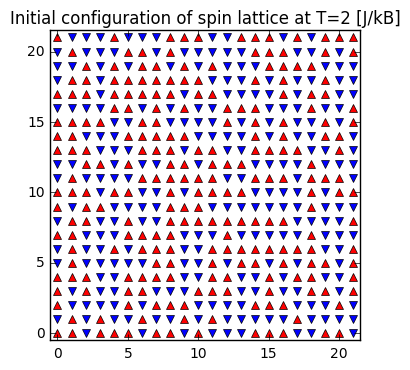

In [95]:
Ising_T2 = lattice(22, 2)
Ising_T2.plot_lattice(title="Initial configuration of spin lattice at T=2 [J/kB]")

In [96]:
Ising_T2.wolff(5000)

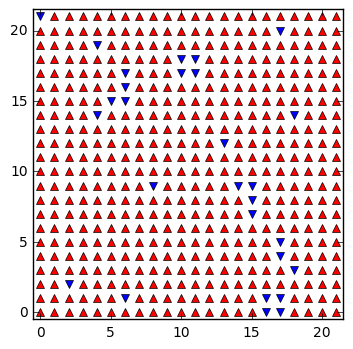

In [97]:
Ising_T2.plot_lattice()

In [118]:
print np.mean(np.abs(Ising_T2.magnetization))
print np.var(np.abs(Ising_T2.magnetization))
print np.mean(Ising_T2.energy)
print np.var(Ising_T2.energy)

0.909754545455
0.00268599152449
-1.74159834711
0.0100983487767


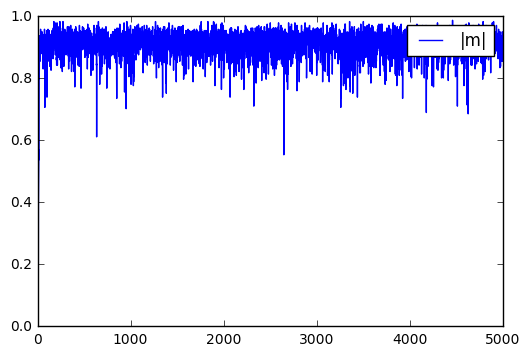

In [119]:
plt.plot(xrange(len(Ising_T2.magnetization)), np.abs(Ising_T2.magnetization), label = "|m|")
plt.legend()
plt.show()

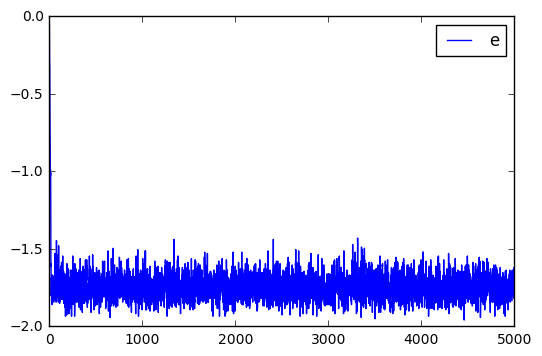

In [100]:
plt.plot(xrange(len(Ising_T2.energy)), Ising_T2.energy, label = "e")
plt.legend()
plt.show()

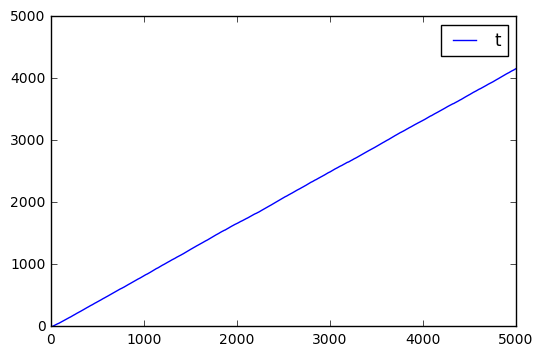

In [102]:
plt.plot(xrange(len(Ising_T2.t)), Ising_T2.t, label = "t")
plt.xlim([0, 5000])
plt.ylim([0, 5000])
plt.legend()
plt.show()

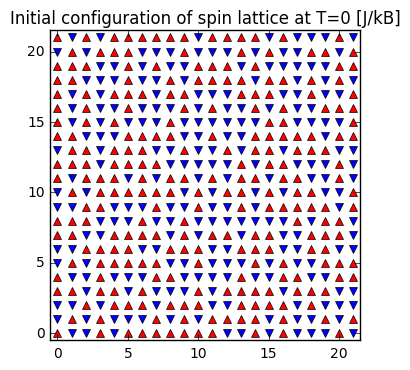

In [116]:
Ising_T0 = lattice(22, 0)
Ising_T0.plot_lattice(title="Initial configuration of spin lattice at T=0 [J/kB]")

In [104]:
Ising_T0.wolff(100)

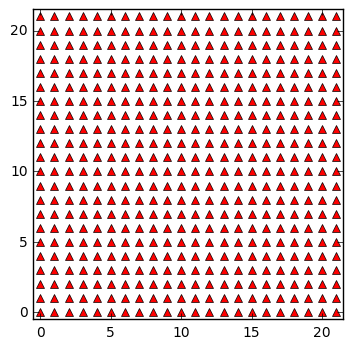

In [105]:
Ising_T0.plot_lattice()

In [106]:
print np.mean(Ising_T0.magnetization)
print np.var(Ising_T0.magnetization)
print np.mean(Ising_T0.energy)
print np.var(Ising_T0.energy)

0.0050826446281
0.987023036336
-1.98115702479
0.0213743323543


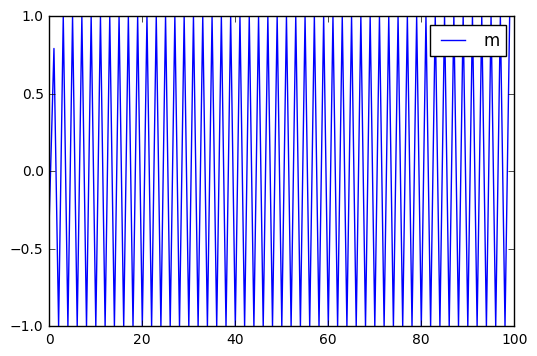

In [107]:
plt.plot(xrange(len(Ising_T0.magnetization)), Ising_T0.magnetization, label = "m")
plt.legend()
plt.show()

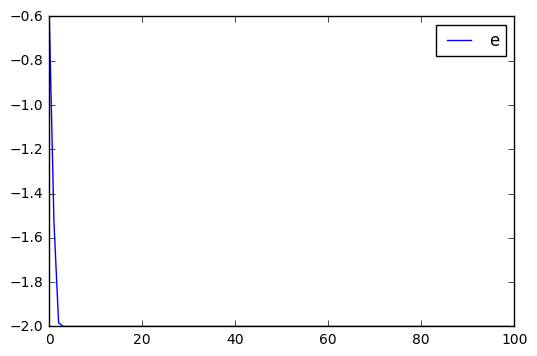

In [108]:
plt.plot(xrange(len(Ising_T0.energy)), Ising_T0.energy, label = "e")
plt.legend()
plt.show()

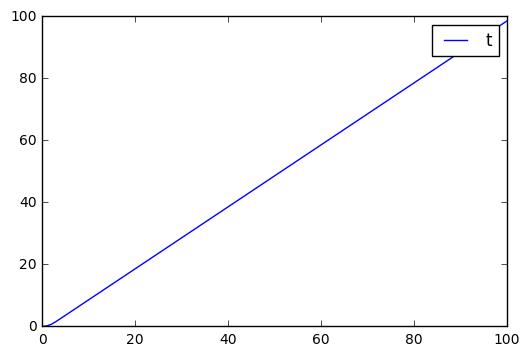

In [109]:
plt.plot(xrange(len(Ising_T0.t)), Ising_T0.t, label = "t")
plt.legend()
plt.show()

In [113]:
Ising_systems_T0 = []
for i in xrange(50):
    Ising_systems_T0.append(lattice(22, 0))

In [114]:
for system in Ising_systems_T0:
    system.wolff(100)

In [115]:
for i in xrange(len(Ising_systems_T0)):
    print i, Ising_systems_T0[i].magnetization[-1]

0 -1.0
1 1.0
2 -1.0
3 1.0
4 -1.0
5 -1.0
6 1.0
7 -1.0
8 -1.0
9 -1.0
10 1.0
11 1.0
12 -1.0
13 -1.0
14 -1.0
15 1.0
16 -1.0
17 1.0
18 1.0
19 1.0
20 -1.0
21 1.0
22 -1.0
23 1.0
24 1.0
25 -1.0
26 -1.0
27 1.0
28 1.0
29 -1.0
30 -1.0
31 1.0
32 1.0
33 1.0
34 -1.0
35 -1.0
36 1.0
37 -1.0
38 1.0
39 -1.0
40 1.0
41 1.0
42 -1.0
43 1.0
44 1.0
45 -1.0
46 -1.0
47 1.0
48 -1.0
49 1.0


At $T=2$, the system has a finite magnetization and the $t_{Wolff}$ is again linear, with an increase in the coefficient (now it is almost $1$).   
At $T=0$ the system is either in the configuration $m=1$ or $m=-1$. The convergence is really fast (a few steps) and $t_{Wolff}$ increases linearly with coefficient $\simeq 1$. We also notice that the system does not get stuck in intermediate configurations anymore.

## FINITE SIZE SCALING